<a href="https://colab.research.google.com/github/Pedro-Boechat/trainee/blob/main/Periodo6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import time
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [37]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

dataset_path = '/content/gdrive/MyDrive/Musical_instruments_reviews.csv'

Mounted at /content/gdrive


In [101]:
df = pd.read_csv(dataset_path)

In [20]:
df.tail()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
10256,A14B2YH83ZXMPP,B00JBIVXGC,Lonnie M. Adams,"[0, 0]","Great, just as expected. Thank to all.",5.0,Five Stars,1405814400,"07 20, 2014"
10257,A1RPTVW5VEOSI,B00JBIVXGC,Michael J. Edelman,"[0, 0]",I've been thinking about trying the Nanoweb st...,5.0,"Long life, and for some players, a good econom...",1404259200,"07 2, 2014"
10258,AWCJ12KBO5VII,B00JBIVXGC,Michael L. Knapp,"[0, 0]",I have tried coated strings in the past ( incl...,4.0,Good for coated.,1405987200,"07 22, 2014"
10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,"Rick Langdon ""Scriptor""","[0, 0]","Well, MADE by Elixir and DEVELOPED with Taylor...",4.0,Taylor Made,1404172800,"07 1, 2014"
10260,A2WA8TDCTGUADI,B00JBIVXGC,TheTerrorBeyond,"[0, 0]","These strings are really quite good, but I wou...",4.0,"These strings are really quite good, but I wou...",1405468800,"07 16, 2014"


In [50]:
for col in df.columns:
    print(col, df[col].isnull().sum())

reviewerID 0
asin 0
reviewerName 0
helpful 0
reviewText 0
overall 0
summary 0
unixReviewTime 0
reviewTime 0


In [102]:
df = df.dropna()

In [103]:
rws = df.loc[:, ['reviewText', 'overall', 'summary']]

In [73]:
rws['reviewText'] = rws['reviewText'].apply(word_tokenize)
rws.head()

,reviewText,overall,summary
0,"[Not, much, to, write, about, here, ,, but, it...",5.0,good
1,"[The, product, does, exactly, as, it, should, ...",5.0,Jake
2,"[The, primary, job, of, this, device, is, to, ...",5.0,It Does The Job Well
3,"[Nice, windscreen, protects, my, MXL, mic, and...",5.0,GOOD WINDSCREEN FOR THE MONEY
4,"[This, pop, filter, is, great, ., It, looks, a...",5.0,No more pops when I record my vocals.


In [74]:
rws['reviewText'] = rws['reviewText'].apply(lambda x: [word.lower() for word in x])
rws.head()

,reviewText,overall,summary
0,"[not, much, to, write, about, here, ,, but, it...",5.0,good
1,"[the, product, does, exactly, as, it, should, ...",5.0,Jake
2,"[the, primary, job, of, this, device, is, to, ...",5.0,It Does The Job Well
3,"[nice, windscreen, protects, my, mxl, mic, and...",5.0,GOOD WINDSCREEN FOR THE MONEY
4,"[this, pop, filter, is, great, ., it, looks, a...",5.0,No more pops when I record my vocals.


In [75]:
punc = string.punctuation
rws['reviewText'] = rws['reviewText'].apply(lambda x: [word for word in x if word not in punc])
rws.head()

,reviewText,overall,summary
0,"[not, much, to, write, about, here, but, it, d...",5.0,good
1,"[the, product, does, exactly, as, it, should, ...",5.0,Jake
2,"[the, primary, job, of, this, device, is, to, ...",5.0,It Does The Job Well
3,"[nice, windscreen, protects, my, mxl, mic, and...",5.0,GOOD WINDSCREEN FOR THE MONEY
4,"[this, pop, filter, is, great, it, looks, and,...",5.0,No more pops when I record my vocals.


In [76]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
rws['reviewText'] = rws['reviewText'].apply(lambda x: [word for word in x if word not in stop_words])
rws.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,reviewText,overall,summary
0,"[much, write, exactly, 's, supposed, filters, ...",5.0,good
1,"[product, exactly, quite, affordable.i, realiz...",5.0,Jake
2,"[primary, job, device, block, breath, would, o...",5.0,It Does The Job Well
3,"[nice, windscreen, protects, mxl, mic, prevent...",5.0,GOOD WINDSCREEN FOR THE MONEY
4,"[pop, filter, great, looks, performs, like, st...",5.0,No more pops when I record my vocals.


In [77]:
nltk.download('averaged_perceptron_tagger')

rws['reviewText'] = rws['reviewText'].apply(nltk.tag.pos_tag)
rws.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,reviewText,overall,summary
0,"[(much, JJ), (write, WP), (exactly, RB), ('s, ...",5.0,good
1,"[(product, NN), (exactly, RB), (quite, RB), (a...",5.0,Jake
2,"[(primary, JJ), (job, NN), (device, NN), (bloc...",5.0,It Does The Job Well
3,"[(nice, JJ), (windscreen, JJ), (protects, NNS)...",5.0,GOOD WINDSCREEN FOR THE MONEY
4,"[(pop, NN), (filter, NN), (great, JJ), (looks,...",5.0,No more pops when I record my vocals.


In [78]:
nltk.download('wordnet')

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
rws['reviewText'] = rws['reviewText'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
rws.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,reviewText,overall,summary
0,"[(much, a), (write, n), (exactly, r), ('s, n),...",5.0,good
1,"[(product, n), (exactly, r), (quite, r), (affo...",5.0,Jake
2,"[(primary, a), (job, n), (device, n), (block, ...",5.0,It Does The Job Well
3,"[(nice, a), (windscreen, a), (protects, n), (m...",5.0,GOOD WINDSCREEN FOR THE MONEY
4,"[(pop, n), (filter, n), (great, a), (looks, v)...",5.0,No more pops when I record my vocals.


In [79]:
wnl = WordNetLemmatizer()
rws['reviewText'] = rws['reviewText'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
rws.head()

,reviewText,overall,summary
0,"[much, write, exactly, 's, suppose, filter, po...",5.0,good
1,"[product, exactly, quite, affordable.i, realiz...",5.0,Jake
2,"[primary, job, device, block, breath, would, o...",5.0,It Does The Job Well
3,"[nice, windscreen, protects, mxl, mic, prevent...",5.0,GOOD WINDSCREEN FOR THE MONEY
4,"[pop, filter, great, look, performs, like, stu...",5.0,No more pops when I record my vocals.


Juntando todos os passos acima numa função, obtemos:

In [104]:
nltk.download('wordnet')

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def preprocessnltk(rws):
  rws['reviewText'] = rws['reviewText'].apply(word_tokenize)

  rws['reviewText'] = rws['reviewText'].apply(lambda x: [word.lower() for word in x])
 
  punc = string.punctuation
  rws['reviewText'] = rws['reviewText'].apply(lambda x: [word for word in x if word not in punc])

  nltk.download('stopwords')
  stop_words = set(stopwords.words('english'))
  rws['reviewText'] = rws['reviewText'].apply(lambda x: [word for word in x if word not in stop_words])

  nltk.download('averaged_perceptron_tagger')
  rws['reviewText'] = rws['reviewText'].apply(nltk.tag.pos_tag)

  rws['reviewText'] = rws['reviewText'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

  wnl = WordNetLemmatizer()
  rws['reviewText'] = rws['reviewText'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

  return rws

rws = preprocessnltk(rws)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [106]:
rws

,reviewText,overall,summary
0,"[much, write, exactly, 's, suppose, filter, po...",5.0,good
1,"[product, exactly, quite, affordable.i, realiz...",5.0,Jake
2,"[primary, job, device, block, breath, would, o...",5.0,It Does The Job Well
3,"[nice, windscreen, protects, mxl, mic, prevent...",5.0,GOOD WINDSCREEN FOR THE MONEY
4,"[pop, filter, great, look, performs, like, stu...",5.0,No more pops when I record my vocals.
...,...,...,...
10256,"[great, expect, thank]",5.0,Five Stars
10257,"['ve, think, try, nanoweb, string, bit, put, h...",5.0,"Long life, and for some players, a good econom..."
10258,"[try, coated, string, past, include, elixir, n...",4.0,Good for coated.
10259,"[well, make, elixir, develop, taylor, guitar, ...",4.0,Taylor Made


# Bag of words

In [ ]:
phrases = ["Eu gosto muito deste filme", 'Eu odeio este filme']

In [105]:
vect = CountVectorizer()
vect.fit(rws['reviewText'])

AttributeError: ignored

In [87]:
print("Tamanho: {}".format(len(vect.vocabulary_)))
print("Conteúdo: {}".format(vect.vocabulary_))

Tamanho: 20541
Conteúdo: {'not': 12273, 'much': 11852, 'to': 18430, 'write': 20342, 'about': 970, 'here': 8832, 'but': 3201, 'it': 9846, 'does': 5828, 'exactly': 6772, 'what': 20016, 'supposed': 17589, 'filters': 7265, 'out': 12694, 'the': 18064, 'pop': 13635, 'sounds': 16727, 'now': 12319, 'my': 11950, 'recordings': 14617, 'are': 1801, 'more': 11751, 'crisp': 4789, 'is': 9817, 'one': 12530, 'of': 12454, 'lowest': 10858, 'prices': 13887, 'on': 12527, 'amazon': 1508, 'so': 16564, 'might': 11467, 'as': 1880, 'well': 19984, 'buy': 3228, 'they': 18174, 'honestly': 8992, 'work': 20267, 'same': 15515, 'despite': 5370, 'their': 18099, 'pricing': 13892, 'product': 13960, 'should': 16123, 'and': 1598, 'quite': 14322, 'affordable': 1292, 'did': 5472, 'realized': 14489, 'was': 19835, 'double': 5878, 'screened': 15713, 'until': 19293, 'arrived': 1849, 'even': 6729, 'better': 2583, 'than': 18048, 'had': 8529, 'expected': 6887, 'an': 1576, 'added': 1179, 'bonus': 2817, 'screens': 15715, 'carries': 3

In [88]:
bagofwords = vect.transform(rws['reviewText'])

In [ ]:
print(bagofwords)

In [90]:
print(bagofwords.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [92]:
vect.get_feature_names_out()

array(['00', '000', '000s', ..., 'zylgian', 'zz', 'zzounds'], dtype=object)

# TFIDF

In [ ]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(bagofwords)
feature_names = vectorizer.get_feature_names()


TF-IDF is a method which gives us a numerical weightage of words which reflects how important the particular word is to a document in a corpus

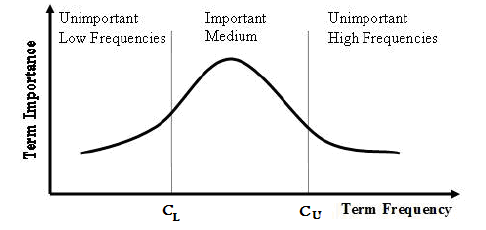

A frequência de termos quando utilizada pode ser eficaz, porém alguns termos que não são eliminados podem atrapalhar a análise. Existem algumas palavras que são muito comuns e se repetem por todos os documentos de texto. Elas possuem significado e não podem ser eliminadas no pré-processamento. 

Para realizar uma análise mais precisa do corpus utilizamos não mais apenas a frequência simples e sim a frequência multiplicada pelo inverso da frequência considerando o conjunto completo de documentos. Por exemplo: imagine um conjunto de 150 documentos no qual a palavra “claro”: aparece em 149 documentos, “médico”: em 98 , “plantas”: em 89.

A técnica do TF-IDF desconsidera as palavras com maior frequência entre documentos e dá maior importância para as palavras que tem maior frequência e não estão presentes em muitos documentos.

tf-idf = term_frequency * inverse_document_frequency

term_frequency = number of times a given term appears in document

inverse_document_frequency = log(total number of documents / number of documents with term) + 1*****

Quanto maior o valor, mais relevante é a palavra

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
pd.set_option("max_rows", 600)
from pathlib import Path  
import glob

In [ ]:
dataset.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [ ]:
tfidf_vectorizer = TfidfVectorizer(input=dataset, stop_words='english')

In [ ]:
dataset['reviewText']

In [ ]:
tfidf_vector = tfidf_vectorizer.fit_transform(dataset['reviewText'])

ValueError: ignored